Testing for Julia code

In [23]:
function cubic_spline(x_grid, f_grid; extrapolation="None")
    # Check for valid input
    if length(x_grid) != length(f_grid)
        error("x_grid and f_grid must have the same length")
    end
    if length(x_grid) < 3
        error("At least 3 points are required for cubic spline interpolation")
    end
    if !issorted(x_grid)
        error("x_grid must be sorted in ascending order")
    end
    if length(unique(x_grid)) != length(x_grid)
        error("x_grid must have unique values")
    end
    if extrapolation ∉ ("None", "Flat", "Linear", "Cubic")
        error("Invalid extrapolation method. Choose from 'None', 'Flat', 'Linear', or 'Cubic'")
    end

    n = length(x_grid)
    h = x_grid[2:n] - x_grid[1:n-1]  # Now handles unevenly spaced points

    # Construct the tridiagonal matrix (Not-a-Knot condition for Cubic extrapolation)
    A = zeros(n, n)
    if extrapolation == "Cubic"
        A[1, 1] = h[2]
        A[1, 2] = -(h[1] + h[2])
        A[1, 3] = h[1]
        A[n, n - 2] = h[n - 1]
        A[n, n - 1] = -(h[n - 2] + h[n - 1])
        A[n, n] = h[n - 2]
    else  # Natural boundary conditions for other extrapolation methods
        A[1, 1] = 1.0
        A[n, n] = 1.0
    end

    for i in 2:n-1
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]
    end

    # Construct the right-hand side vector
    b = zeros(n)
    for i in 2:n-1
        b[i] = 3 * ((f_grid[i+1] - f_grid[i]) / h[i] - (f_grid[i] - f_grid[i-1]) / h[i-1])
    end

    # Solve the system to get second derivatives (coefficients for the cubic terms)
    c = A \ b

    # Calculate coefficients for linear, quadratic, and constant terms
    a = f_grid
    d = (c[2:n] - c[1:n-1]) ./ (3 * h)
    b = (a[2:n] - a[1:n-1]) ./ h - h .* (c[2:n] + 2 * c[1:n-1]) / 3

    # Create a closure that evaluates the spline at a given point
    function f_spline(x_new)
        # Handle extrapolation
        if x_new < x_grid[1] || x_new > x_grid[end]
            if extrapolation == "None"
                error("Extrapolation is not allowed. x_new is outside the range of x_grid.")
            elseif extrapolation == "Flat"
                return x_new < x_grid[1] ? f_grid[1] : f_grid[end]
            elseif extrapolation == "Linear"
                if x_new < x_grid[1]
                    slope = b[1]
                    return f_grid[1] + slope * (x_new - x_grid[1])
                else
                    # Find the correct interval for the right boundary
                    i = n - 1
                    # Corrected slope calculation for right boundary
                    slope = b[i] + 2 * c[i] * h[i] + 3 * d[i] * h[i]^2
                    # Corrected anchor point: using the spline's value at the endpoint
                    return (a[i] + b[i] * h[i] + c[i] * h[i]^2 + d[i] * h[i]^3) + slope * (x_new - x_grid[i+1])
                end
            end  # Cubic (Not-a-Knot) handled below
        end

        # Find the correct interval
        i = max(1, min(searchsortedlast(x_grid, x_new), n - 1))

        # Evaluate the cubic polynomial
        dx = x_new - x_grid[i]
        return a[i] + b[i] * dx + c[i] * dx^2 + d[i] * dx^3
    end

    return f_spline
end

cubic_spline (generic function with 1 method)

In [21]:
using Plots

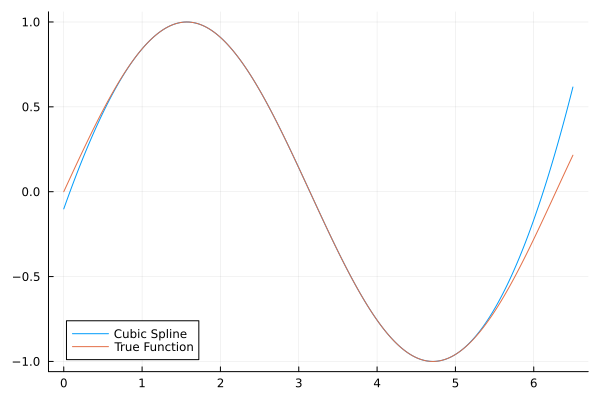

In [28]:
x_grid = [1, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0, 4.25, 4.5, 4.75, 5.0]
f_grid = sin.(x_grid)

# Create the spline interpolation function with linear extrapolation
f_spline = cubic_spline(x_grid, f_grid, extrapolation="Cubic")

# Evaluate the spline at a new point
x_new = 0.0:0.01:6.5

plot(x_new, f_spline.(x_new), label="Cubic Spline")
plot!(x_new, sin.(x_new), label="True Function")